# Notebook dedicated to compute geometric observables that discriminate directional patterns using hit spatial distribution

Ideas: Centroid, Inertia Tensor.

In [5]:
import numpy as np
import pandas as pd
import random 

import glob
import re
import os

import seaborn as sn
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

# Load Numpy files

In [6]:
# ============ Data Cuts Settings ============

posr_cut = 5500

energy_inf_cut = 2.5
energy_sup_cut = 12

time_res_inf_cut = -1
time_res_sup_cut = 5

nhits_cut = 20 #Nhits cut to be applied after the time residual cuts

In [14]:
main_dir = f'E:/Data/solars/mc/2p2PPO/ML Data/np_arrays/Train/E_{energy_inf_cut}_{energy_sup_cut}_MeV_R_{posr_cut}_mm_Delta_{time_res_inf_cut}_{time_res_sup_cut}_ns/'

solar_fpattern = 'SolarNue_'
tl208_fpattern = '208Tl_'

observable_name = ['evtid', 'energy', 'posr', 'cos_alpha', 'hit_residual', 'hit_pmtQHS', 'position', 'hitpmt_xyz']

solar_dict = {var_i: np.array([]) for var_i in observable_name}
tl208_dict = {var_i: np.array([]) for var_i in observable_name}

#Load each varibles within a loop of variables and fill the dictionaries
#Loop over var names
for var_i in observable_name:
    #create flist for the multiple var_i observables (exm: evID_0, evID_1, ...)
    solar_var_i_flist = glob.glob(main_dir + solar_fpattern + var_i + '*.npy')
    tl208_var_i_flist = glob.glob(main_dir + tl208_fpattern + var_i + '*.npy')

    #Loop over flist:
    for solar_file_i in solar_var_i_flist:
        load_solar_var_i = np.load(solar_file_i)
        solar_dict[var_i] = np.append(solar_dict[var_i], load_solar_var_i)

    for tl208_file_i in tl208_var_i_flist:
        load_208tl_var_i = np.load(tl208_file_i)
        tl208_dict[var_i] = np.append(tl208_dict[var_i], load_208tl_var_i)

# Reshape the coordinate geometric observables
solar_dict['position'] = solar_dict['position'].reshape(-1, 3)
solar_dict['hitpmt_xyz'] = solar_dict['hitpmt_xyz'].reshape(-1, 3)

tl208_dict['position'] = tl208_dict['position'].reshape(-1, 3)
tl208_dict['hitpmt_xyz'] = tl208_dict['hitpmt_xyz'].reshape(-1, 3)

## Remove Redundant Values

In [16]:
# List of Observables
nonper_hit_observables_name = ['evtid', 'posr', 'energy', 'position'] 
per_hit_observables = ['cos_alpha', 'hit_residual', 'hit_pmtQHS', 'hitpmt_xyz']


# ============= Solar Processing =============

#Extract the redundant evID
solar_evID = solar_dict['evtid']

# Empty lists which will contain all the observables in the suitable shape
solar_dict_ev = {var_i: [] for var_i in nonper_hit_observables_name + per_hit_observables}

#evID index break list
solar_data_break_i = [0]  # array whose elements are the index from where an event start and end.

solar_N_data = len(solar_evID)

print('Looking for break index in solars evID')
for i_dx in range(solar_N_data - 1):
    if solar_evID[i_dx] != solar_evID[i_dx+1]:
        solar_data_break_i.append(i_dx+1)

#add the last index to complete the data_break_i list
solar_data_break_i.append(solar_N_data - 1)

N_solar_terms = len(solar_data_break_i)

#Start to save the non-redundant (non-per-hit) values and separate the time residuals and angles for each event
#Solar Loop
print(f'saving the observables for solars')
for i_dx in range(N_solar_terms - 1):
    init_i = solar_data_break_i[i_dx]
    final_i = solar_data_break_i[i_dx+1]
    
    for var_i in nonper_hit_observables_name:
        nonper_hit_var_i_value = solar_dict[var_i][init_i : final_i][0]
        solar_dict_ev[var_i].append(nonper_hit_var_i_value)

    for var_i in per_hit_observables:
        per_hit_var_i_values = solar_dict[var_i][init_i : final_i]
        solar_dict_ev[var_i].append(per_hit_var_i_values)

#Transform to array
print('Transforming solars to np.array')
for var_i in nonper_hit_observables_name:
    print(f'transforming to np.array {var_i}')
    solar_dict_ev[var_i] = np.array(solar_dict_ev[var_i])

Looking for break index in solars evID
saving the observables for solars
Transforming solars to np.array
transforming to np.array evtid
transforming to np.array posr
transforming to np.array energy
transforming to np.array position


In [17]:
# ============= Tl208 Processing =============

#Extract the redundant evID
tl208_evID = tl208_dict['evtid']

# Empty lists which will contain all the observables in the suitable shape
tl208_dict_ev = {var_i: [] for var_i in nonper_hit_observables_name + per_hit_observables}

#evID index break list
tl208_data_break_i = [0]  # array whose elements are the index from where an event start and end.

tl208_N_data = len(tl208_evID)

print('Looking for break index in Tl208 evID')
for i_dx in range(tl208_N_data - 1):
    if tl208_evID[i_dx] != tl208_evID[i_dx+1]:
        tl208_data_break_i.append(i_dx+1)

#add the last index to complete the data_break_i list
tl208_data_break_i.append(tl208_N_data - 1)

N_tl208_terms = len(tl208_data_break_i)

#Start to save the non-per-hit values and separate the time residuals and angles for each event
# Loop on Events
print(f'saving the observables for Tl208')
for i_dx in range(N_tl208_terms - 1):
    init_i = tl208_data_break_i[i_dx]
    final_i = tl208_data_break_i[i_dx+1]
    
    for var_i in nonper_hit_observables_name:
        nonper_hit_var_i_value = tl208_dict[var_i][init_i : final_i][0]
        tl208_dict_ev[var_i].append(nonper_hit_var_i_value)

    for var_i in per_hit_observables:
        per_hit_var_i_values = tl208_dict[var_i][init_i : final_i]
        tl208_dict_ev[var_i].append(per_hit_var_i_values)

#Transform to array
print('Transforming Tl208 to np.array')
for var_i in nonper_hit_observables_name:
    print(f'transforming to np.array {var_i}')
    tl208_dict_ev[var_i] = np.array(tl208_dict_ev[var_i])

Looking for break index in Tl208 evID
saving the observables for Tl208
Transforming Tl208 to np.array
transforming to np.array evtid
transforming to np.array posr
transforming to np.array energy
transforming to np.array position


# Note: If things doesnt got well, try to implement a charge cut on the dataset (you should resave the entire dataset but with QHS cut ...)

# Test with Geometric-Charge Weighted Observables 

## Charged Centroid
The idea is to find the center of mass (CM) coordinates of the PMTs taking the charge as the mass. Then, build a direction vector using the CM and the reconstructed position. It can be used to:

- Compute the modulus of the vector $|D|$. If $|D| \sim 0$ the event is more isotropic and is a probable background;
- Compare the direction of $D$ and evaluates if it matches with the Sun direction for solar events. For example, the scalar product $D \cdot v_{sun}$ should be close to one if $D$ describes the event direction (actual data set doesn't has the Sun's direction ...);

The charged centroid computation should follows the formula $C_x = \sum_{i}^{PMTs}q_{i}x_{i} / \sum_{i}^{PMTs}q_{i}$

The same for $C_y$ and $C_z$

### Solars Charged Centroid and $\vec{D}$

In [54]:
N_evs = len(solar_dict_ev['evtid']) # Number of events to loop

# ---- Quantities to be used ----
hitpmt_qhs = solar_dict_ev['hit_pmtQHS'] # QHS of the hit PMT
hitpmt_xyz = solar_dict_ev['hitpmt_xyz'] # hit PMT coordinates
position = solar_dict_ev['position']     # Reconstructed Position

C_solars = np.empty((N_evs, 3))         # to save the solar centroid coordinates
D_solars = np.empty((N_evs, 3))         # to save the vector between the solar centroid and the reconstructed position
D_mod_solars = np.empty(N_evs)          # To save the modulo of D vector

for ev_i in range(N_evs):
    
    # Extract observables of the events
    qhs_ev = hitpmt_qhs[ev_i]
    hitpmt_xyz_ev = hitpmt_xyz[ev_i]
    position_ev = position[ev_i]

    # Construct the centroid coordinates (charged weighted formula)
    
    charged_hitpmt_x = hitpmt_xyz_ev[:,0] * qhs_ev
    charged_hitpmt_y = hitpmt_xyz_ev[:,1] * qhs_ev
    charged_hitpmt_z = hitpmt_xyz_ev[:,2] * qhs_ev

    Cx_num = np.sum(charged_hitpmt_x)
    Cx_den = np.sum(qhs_ev)
    Cx = Cx_num/Cx_den

    Cy_num = np.sum(charged_hitpmt_y)
    Cy_den = np.sum(qhs_ev)
    Cy = Cy_num/Cy_den

    Cz_num = np.sum(charged_hitpmt_z)
    Cz_den = np.sum(qhs_ev)
    Cz = Cz_num/Cz_den

    C_ev = np.array([Cx, Cy, Cz]) # Centroid vector for this event
    D_ev = C_ev - position_ev     # Centroid - recons. position vector
    D_mod_ev = np.linalg.norm(D_ev)

    # Save the quantities of interest
    C_solars[ev_i] = C_ev         
    D_solars[ev_i] = D_ev    
    D_mod_solars[ev_i] = D_mod_ev

### Tl208 Charged Centroid and $\vec{D}$

In [55]:


# ---- Quantities to be used ----
N_evs = len(tl208_dict_ev['evtid'])      # Number of events to loop

hitpmt_qhs = tl208_dict_ev['hit_pmtQHS'] # QHS of the hit PMT
hitpmt_xyz = tl208_dict_ev['hitpmt_xyz'] # hit PMT coordinates
position = tl208_dict_ev['position']     # Reconstructed Position

# ---- Quantities to Save ----
C_tl208 = np.empty((N_evs, 3))         # to save the solar centroid coordinates
D_tl208 = np.empty((N_evs, 3))         # to save the vector between the solar centroid and the reconstructed position
D_mod_tl208 = np.empty(N_evs)          # To save the modulo of D vector

for ev_i in range(N_evs):
    
    # Extract observables of the events
    qhs_ev = hitpmt_qhs[ev_i]
    hitpmt_xyz_ev = hitpmt_xyz[ev_i]
    position_ev = position[ev_i]

    # Construct the centroid coordinates (charged weighted formula)
    
    charged_hitpmt_x = hitpmt_xyz_ev[:,0] * qhs_ev
    charged_hitpmt_y = hitpmt_xyz_ev[:,1] * qhs_ev
    charged_hitpmt_z = hitpmt_xyz_ev[:,2] * qhs_ev

    Cx_num = np.sum(charged_hitpmt_x)
    Cx_den = np.sum(qhs_ev)
    Cx = Cx_num/Cx_den

    Cy_num = np.sum(charged_hitpmt_y)
    Cy_den = np.sum(qhs_ev)
    Cy = Cy_num/Cy_den

    Cz_num = np.sum(charged_hitpmt_z)
    Cz_den = np.sum(qhs_ev)
    Cz = Cz_num/Cz_den

    C_ev = np.array([Cx, Cy, Cz])   # Centroid vector for this event
    D_ev = C_ev - position_ev       # Centroid - recons. position vector
    D_mod_ev = np.linalg.norm(D_ev) # Magnitude of D

    # Save the quantities of interest
    C_tl208[ev_i] = C_ev         
    D_tl208[ev_i] = D_ev    
    D_mod_tl208[ev_i] = D_mod_ev

In [56]:
D_mod_tl208

array([3701.57512174, 4103.46953462, 4965.55849428, ..., 4614.01251061,
       5134.84970016, 5209.94842359])

In [57]:
D_mod_solars

array([2766.27526692, 4069.76311598, 3601.49867797, ..., 4615.99233383,
       2479.83605901, 3217.09976443])

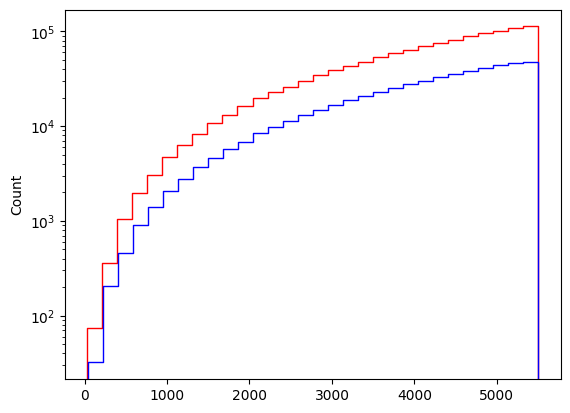

In [60]:
bins = 30

sn.histplot(D_mod_solars, bins = bins, element = 'step', alpha = 0, color = 'red', label = r'$|\vec{D}|$ Solars')
sn.histplot(D_mod_tl208, bins = bins, element = 'step', alpha = 0, color = 'blue', label = r'$|\vec{D}|$ Tl-208')
plt.yscale('log')
plt.show()

## Inertia Tensor

The idea is compute the matrix elements of the Inertia Tensor (IT) using the hit PMT coordinates and the charge as the masses of the PMTs. The time residual values could also be used to compute the PMT 'mass'. Then, compute the principal values of inertia that should describe the hit pattern charged weighted distribution and may distinguish directional events from isotropic events.
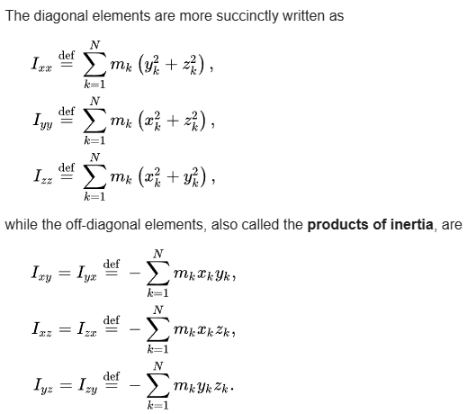

In [162]:
# ==== Control panel to compute the Inertia Tensor ====

#  Energy cut 
en_sup_cut = 4

#  PMT Mass Model 
time_res_exp_decay = False  # Turn True to use time residual exponential decay weighting
tau = 1                     # half-life parameter of decay. tau:[1, 2.5] ns

### Solars Inertia Tensor

In [121]:
solar_dict_ev.keys()

dict_keys(['evtid', 'posr', 'energy', 'position', 'cos_alpha', 'hit_residual', 'hit_pmtQHS', 'hitpmt_xyz'])

In [163]:
# ---- Quantities to be used ----
N_evs = len(solar_dict_ev['evtid'])       # Number of events to loop

energy = solar_dict_ev['energy']          # Reconstructed event energy
hitpmt_qhs = solar_dict_ev['hit_pmtQHS']  # QHS of the hit PMT
hitpmt_xyz = solar_dict_ev['hitpmt_xyz']  # hit PMT coordinates
t_res = solar_dict_ev['hit_residual']     # time residuals

# ---- Quantities to be save ----
IT_eigenval_solar = np.empty((N_evs, 3))
IT_eigenvec_solar = np.empty((N_evs, 3, 3))


for ev_i in range(N_evs):
    
    # Extract observables of the events
    qhs_ev = hitpmt_qhs[ev_i]
    hitpmt_x_ev = hitpmt_xyz[ev_i][:,0]
    hitpmt_y_ev = hitpmt_xyz[ev_i][:,1]
    hitpmt_z_ev = hitpmt_xyz[ev_i][:,2]
    t_res_ev = t_res[ev_i]

    # ==== Inertia Tensor ====

    # --- PMT Mass Calculation ---
    if time_res_exp_decay:
        # Model with exponential decay on t_res 
        pmt_mass = qhs_ev * np.exp(-t_res_ev/tau)

    else:
        pmt_mass = qhs_ev

    # ---- Element Computation ----
    Ixx = np.sum(pmt_mass * (hitpmt_y_ev**2 + hitpmt_z_ev**2))
    Iyy = np.sum(pmt_mass * (hitpmt_x_ev**2 + hitpmt_z_ev**2))
    Izz = np.sum(pmt_mass * (hitpmt_x_ev**2 + hitpmt_y_ev**2))

    Ixy = -np.sum(pmt_mass * hitpmt_x_ev * hitpmt_y_ev)
    Ixz = -np.sum(pmt_mass * hitpmt_x_ev * hitpmt_z_ev)
    Iyz = -np.sum(pmt_mass * hitpmt_y_ev * hitpmt_z_ev)

    # ---- Inertia Tensor Construction ----
    IT = np.array([[Ixx, Ixy, Ixz],
                   [Ixy, Iyy, Iyz],
                   [Ixz, Iyz, Izz]])

    # ---- Eigenval. and eigenvec. computation ----
    eigenvals, eigenvecs = np.linalg.eigh(IT)

    # ---- Save the Results ----
    IT_eigenval_solar[ev_i] = eigenvals
    IT_eigenvec_solar[ev_i] = eigenvecs

IT_eigenval_solar = IT_eigenval_solar[energy < en_sup_cut]
IT_eigenvec_solar = IT_eigenvec_solar[energy < en_sup_cut]

# ==== Compute observables from the eigenvales ====
eigval_1, eigval_2, eigval_3 = IT_eigenval_solar[:,0], IT_eigenval_solar[:,1], IT_eigenval_solar[:,2]  # the eigenvales must verify eigval_1 < eigval_2 < eigval_3

# Sphericity
sphe_solar = 3*eigval_2 / (eigval_1 + eigval_2 + eigval_3)

# Planarity
plan_solar = (3/2)*(eigval_2 + eigval_3 - eigval_1)

#Ratios
eigval_ratio21_solar = eigval_2/eigval_1
eigval_ratio31_solar = eigval_3/eigval_1

### Tl208 Inertia Tensor

In [164]:
# ---- Quantities to be used ----
N_evs = len(tl208_dict_ev['evtid'])      # Number of events to loop

energy = tl208_dict_ev['energy']         # Reconstructed event energy
hitpmt_qhs = tl208_dict_ev['hit_pmtQHS'] # QHS of the hit PMT
hitpmt_xyz = tl208_dict_ev['hitpmt_xyz'] # hit PMT coordinates
t_res = tl208_dict_ev['hit_residual']    # time residuals

# ---- Quantities to be save ----
IT_eigenval_tl208 = np.empty((N_evs, 3))
IT_eigenvec_tl208 = np.empty((N_evs, 3, 3))


for ev_i in range(N_evs):
    
    # Extract observables of the events
    qhs_ev = hitpmt_qhs[ev_i]
    hitpmt_x_ev = hitpmt_xyz[ev_i][:,0]
    hitpmt_y_ev = hitpmt_xyz[ev_i][:,1]
    hitpmt_z_ev = hitpmt_xyz[ev_i][:,2]
    t_res_ev = t_res[ev_i]

    # ==== Inertia Tensor ====

    # --- PMT Mass Calculation ---
    if time_res_exp_decay:
        # Model with exponential decay on t_res 
        pmt_mass = qhs_ev * np.exp(-t_res_ev/tau)

    else:
        pmt_mass = qhs_ev

    # ---- Element Computation ----
    Ixx = np.sum(pmt_mass * (hitpmt_y_ev**2 + hitpmt_z_ev**2))
    Iyy = np.sum(pmt_mass * (hitpmt_x_ev**2 + hitpmt_z_ev**2))
    Izz = np.sum(pmt_mass * (hitpmt_x_ev**2 + hitpmt_y_ev**2))

    Ixy = -np.sum(pmt_mass * hitpmt_x_ev * hitpmt_y_ev)
    Ixz = -np.sum(pmt_mass * hitpmt_x_ev * hitpmt_z_ev)
    Iyz = -np.sum(pmt_mass * hitpmt_y_ev * hitpmt_z_ev)

    # ---- Inertia Tensor Construction ----
    IT = np.array([[Ixx, Ixy, Ixz],
                   [Ixy, Iyy, Iyz],
                   [Ixz, Iyz, Izz]])

    # ---- Eigenval. and eigenvec. computation ----
    eigenvals, eigenvecs = np.linalg.eigh(IT)

    # ---- Save the Results ----
    IT_eigenval_tl208[ev_i] = eigenvals
    IT_eigenvec_tl208[ev_i] = eigenvecs

# Energy cut
IT_eigenval_tl208 = IT_eigenval_tl208[energy < en_sup_cut]
IT_eigenvec_tl208 = IT_eigenvec_tl208[energy < en_sup_cut]

# ==== Compute observables from the eigenvales ====
eigval_1, eigval_2, eigval_3 = IT_eigenval_tl208[:,0], IT_eigenval_tl208[:,1], IT_eigenval_tl208[:,2]  # the eigenvales must verify eigval_1 < eigval_2 < eigval_3

# Sphericity
sphe_tl208 = 3*eigval_2 / (eigval_1 + eigval_2 + eigval_3)

# Planarity
plan_tl208 = (3/2)*(eigval_2 + eigval_3 - eigval_1)

#Ratios
eigval_ratio21_tl208 = eigval_2/eigval_1
eigval_ratio31_tl208 = eigval_3/eigval_1

### Plots

#### Eigenvalues

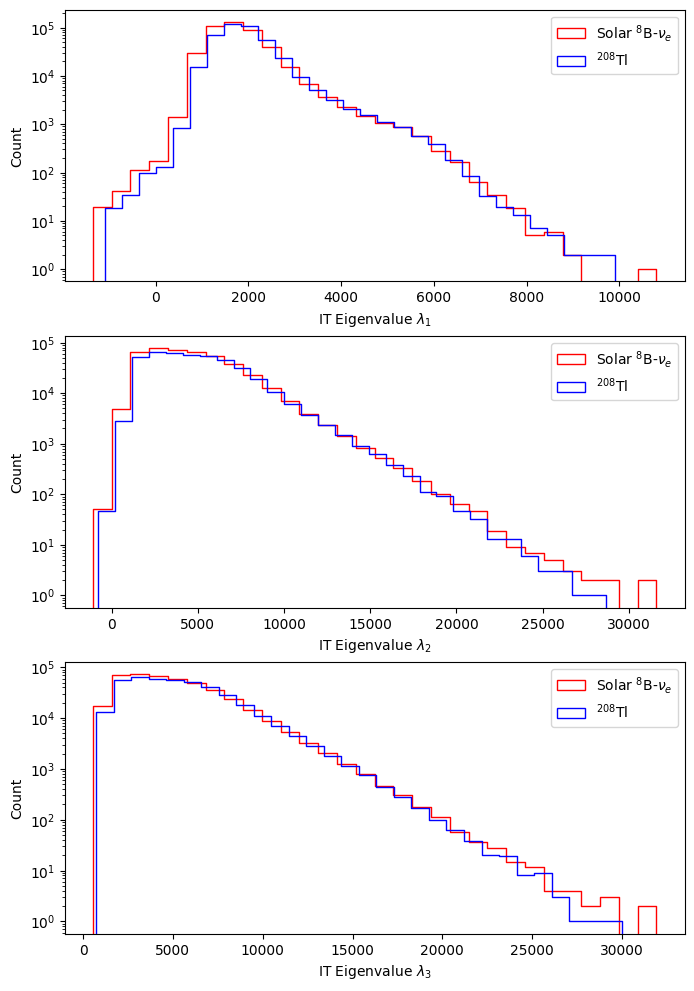

In [165]:
# ==== Eigenvalues separation ====

eigval_solar = [IT_eigenval_solar[:, 0], IT_eigenval_solar[:, 1], IT_eigenval_solar[:, 2]]
eigval_tl208 = [IT_eigenval_tl208[:, 0], IT_eigenval_tl208[:, 1], IT_eigenval_tl208[:, 2]]

# ==== Plot of eigenvalues ====

fig, axes = plt.subplots(3, 1, figsize=(8, 12))

bins = 30

for i in range(3):

    axis = axes[i]
    sn.histplot(eigval_solar[i], bins = bins, ax = axis, color = 'red', element = 'step', alpha = 0, label = r'Solar $^{8}$B-$\nu_e$')
    sn.histplot(eigval_tl208[i], bins = bins, ax = axis, color = 'blue', element = 'step', alpha = 0, label = r'$^{208}$Tl')

    axis.set_xlabel(rf'IT Eigenvalue $\lambda_{i+1}$')
    
    axis.legend(loc = 'best')
    axis.set_yscale('log')
#plt.savefig('IT_eigenvals.png', dpi = 1000 , format = 'png')
plt.show()

#### Sphericity

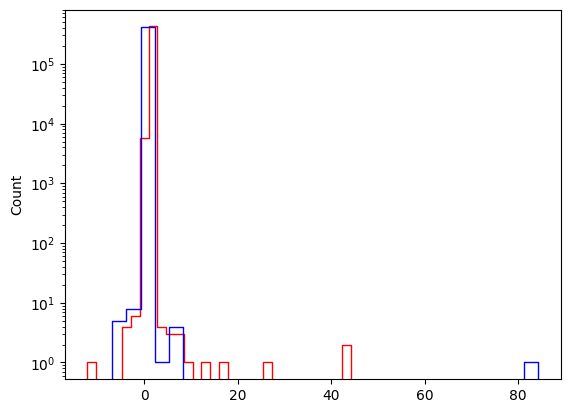

In [166]:
bins = 30
sn.histplot(sphe_solar, bins = bins, color = 'red', element = 'step', alpha = 0, label = r'Solar $^{8}$B-$\nu_e$')
sn.histplot(sphe_tl208, bins = bins, color = 'blue', element = 'step', alpha = 0, label = r'Solar $^{8}$B-$\nu_e$')

plt.yscale('log')
plt.show()

#### Planarity

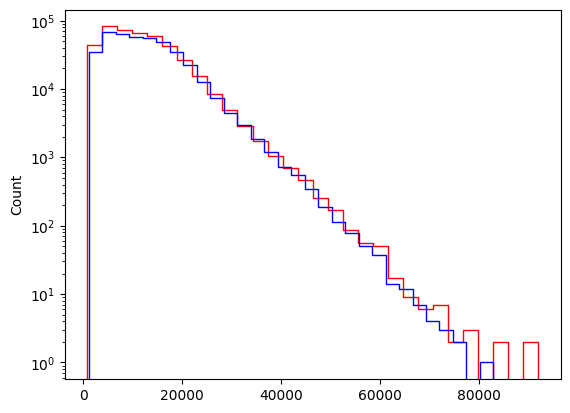

In [167]:
bins = 30
sn.histplot(plan_solar, bins = bins, color = 'red', element = 'step', alpha = 0, label = r'Solar $^{8}$B-$\nu_e$')
sn.histplot(plan_tl208, bins = bins, color = 'blue', element = 'step', alpha = 0, label = r'Solar $^{8}$B-$\nu_e$')

plt.yscale('log')
plt.show()

#### Eigenvalue Ratios

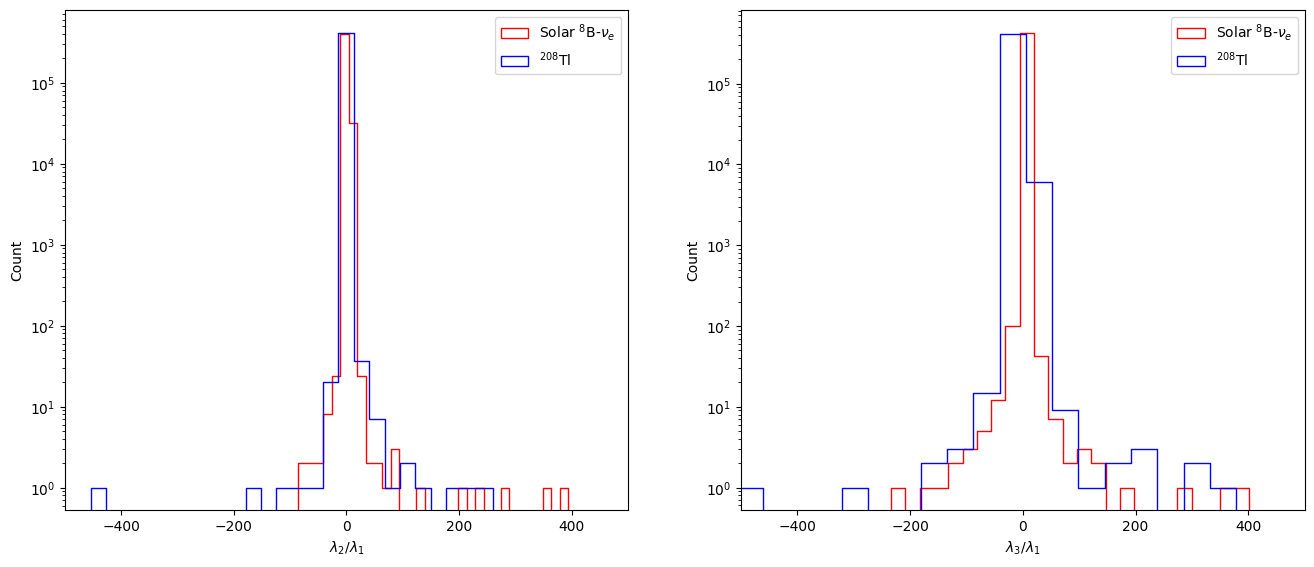

In [168]:
# ==== Sort in list ==== 

eigval_ratios_solar = [eigval_ratio21_solar, eigval_ratio31_solar]
eigval_ratios_tl208 = [eigval_ratio21_tl208, eigval_ratio31_tl208]
x_label = [r'$\lambda_{2}/\lambda_{1}$', r'$\lambda_{3}/\lambda_{1}$']

fig, axes = plt.subplots(1, 2, figsize = (16, 6.5))

bins = 200

for i, ax_i in enumerate(axes):

    sn.histplot(eigval_ratios_solar[i], bins = bins, ax = ax_i, color = 'red', element = 'step', alpha = 0, label = r'Solar $^{8}$B-$\nu_e$')
    sn.histplot(eigval_ratios_tl208[i], bins = bins, ax = ax_i, color = 'blue', element = 'step', alpha = 0, label = r'$^{208}$Tl')

    ax_i.set_xlabel(x_label[i])
    
    ax_i.legend(loc = 'best')
    ax_i.set_yscale('log')

    ax_i.set_xlim(-500, 500)

plt.show()    

# Note: Aunque sean informativas estas features, hay mucha sobreposicion entre fondo y señal. Intentar trabajar en un dataset de alta qhs!